# When Humanitarian Aid Ignores Its Own Data
## An Analytical Deep Dive into Funding, Displacement, and Media Coverage

*A first draft exploring the disconnect between humanitarian needs and funding patterns*

---

### Introduction

This analysis examines three critical datasets in the humanitarian sector:
1. **FTS (Financial Tracking Service)** - Global humanitarian funding flows
2. **DTM (Displacement Tracking Matrix)** - Internal displacement data across 44 countries
3. **GDELT (Global Database of Events, Language, and Tone)** - Media coverage patterns

The central question: Does humanitarian funding follow actual displacement trends, or is it driven by something else entirely?

**Analysis Period**: February 2022 – February 2024 (chosen to capture the Ukraine crisis impact)

**Methodology**: Using Prophet for time-series modeling with quarterly seasonality extraction, normalized comparisons using MinMaxScaler, and quarterly aggregation for trend analysis.

In [2]:
pip install prophet gdeltdoc scikit-learn matplotlib pandas numpy scipy requests jupyter

     ---------------------------------------- 0.0/50.0 kB ? eta -:--:--
     -------- ------------------------------- 10.2/50.0 kB ? eta -:--:--
     -------------------------------------- 50.0/50.0 kB 865.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   - -------------------------------------- 0.4/12.1 MB 12.8 MB/s eta 0:00:01
   -------- ------------------------------- 2.5/12.1 MB 26.4 MB/s eta 0:00:01
   ------------- -------------------------- 4.2/12.1 MB 29.8 MB/s eta 0:00:01
   ----------------------- ---------------- 7.1/12.1 MB 37.6 MB/s eta 0:00:01
   -------------------------------------- - 11.5/12.1 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.1 MB 65.6 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.1 MB 65.6 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.1 MB 65.6 MB/s eta 0:00:01
   ---------------------------------------  12.1/12.1 MB 65.6 MB/s eta 0:00:0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
argilla 1.6.0 requires backoff, which is not installed.
argilla 1.6.0 requires deprecated~=1.2.0, which is not installed.
argilla 1.6.0 requires monotonic, which is not installed.
argilla 1.6.0 requires rich<=13.0.1, which is not installed.
great-expectations 0.18.2 requires marshmallow<4.0.0,>=3.7.1, which is not installed.
streamlit 1.40.1 requires cachetools<6,>=4.0, which is not installed.
streamlit 1.40.1 requires rich<14,>=10.14.0, which is not installed.
unstructured 0.5.12 requires msg-parser, which is not installed.
unstructured 0.5.12 requires pypandoc, which is not installed.
unstructured 0.5.12 requires python-docx, which is not installed.
unstructured 0.5.12 requires python-magic, which is not installed.
unstructured 0.5.12 requires python-pptx, which is not installed.
conda-repo-cli 1.0.75 requires r

In [11]:
# Import necessary libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from gdeltdoc import GdeltDoc, Filters
import warnings
warnings.filterwarnings('ignore')
# Workaround for pandas display bug in Jupyter
pd.set_option('display.notebook_repr_html', False)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

### Helper Functions

In [4]:
def normalize(series):
    """Normalize values to 0-1 range for comparison"""
    scaler = MinMaxScaler()
    return scaler.fit_transform(series.values.reshape(-1, 1))

## Part 1: Humanitarian Funding Data (FTS)

First, let's pull funding data from the Financial Tracking Service. We're using Prophet to model the underlying trends and extract quarterly seasonality patterns, which helps us understand the cyclical nature of humanitarian funding beyond day-to-day fluctuations.

In [9]:
def process_funding_data(funding_df):
    """Process and model funding data with Prophet"""
    print("\nProcessing funding data...")
    
    # Convert date and handle missing values
    funding_df["createdAt"] = pd.to_datetime(funding_df["createdAt"], errors="coerce")
    funding_df = funding_df.dropna(subset=["createdAt"])
    
    # Remove zero or negative funding amounts BEFORE aggregation
    funding_df = funding_df[funding_df["amountUSD"] > 0]
    print(f"  Valid funding records: {len(funding_df):,}")
    
    # Daily aggregation
    funding_by_date = (
        funding_df.groupby(funding_df["createdAt"].dt.date)["amountUSD"]
        .sum()
        .reset_index()
    )
    funding_by_date.columns = ["ds", "y"]
    funding_by_date["ds"] = pd.to_datetime(funding_by_date["ds"])
    
    # Remove any days with zero funding (prevents -inf in log)
    funding_by_date = funding_by_date[funding_by_date["y"] > 0]
    
    # Log transform
    funding_by_date["y"] = np.log1p(funding_by_date["y"])
    
    # Final check: remove any inf or nan values
    funding_by_date = funding_by_date.replace([np.inf, -np.inf], np.nan)
    funding_by_date = funding_by_date.dropna(subset=["y"])
    
    print(f"  Days with valid funding: {len(funding_by_date)}")
    
    # Prophet model with quarterly seasonality
    print("  Training Prophet model...")
    model = Prophet(
        yearly_seasonality=False, 
        weekly_seasonality=False,
        daily_seasonality=False
    )
    model.add_seasonality(name="quarterly", period=91.25, fourier_order=5)
    model.fit(funding_by_date)
    print("  ✓ Model trained successfully")

    forecast = model.predict(model.make_future_dataframe(periods=0))
    
    # Filter to analysis period
    forecast_filtered = forecast[
        (forecast["ds"] >= "2022-02-01") & (forecast["ds"] <= "2024-02-29")
    ]
    
    # Create a completely new dataframe to avoid pandas bug
    result = pd.DataFrame({
        'ds': forecast_filtered["ds"].values,
        'yhat': forecast_filtered["yhat"].values
    })
    
    # Normalize - flatten the result
    yhat_norm = normalize(result["yhat"])
    result["yhat_norm"] = yhat_norm.flatten()  # Flatten to 1D array
    
    return result

# Fetch and process
funding_df = fetch_funding_data([2022, 2023, 2024])
quarterly_funding = process_funding_data(funding_df)

print(f"\n✓ Funding data processed: {len(quarterly_funding)} days")
print(f"  Date range: {quarterly_funding['ds'].min().date()} to {quarterly_funding['ds'].max().date()}")

# Use print to display first few rows
print("\nFirst 5 rows:")
for i in range(min(5, len(quarterly_funding))):
    row = quarterly_funding.iloc[i]
    print(f"  {row['ds'].date()}: yhat={row['yhat']:.2f}, normalized={row['yhat_norm']:.3f}")

Fetching funding data for 2022...
  ✓ Retrieved 200 funding flows
Fetching funding data for 2023...
  ✓ Retrieved 200 funding flows
Fetching funding data for 2024...


14:35:09 - cmdstanpy - INFO - Chain [1] start processing
14:35:09 - cmdstanpy - INFO - Chain [1] done processing


  ✓ Retrieved 200 funding flows

Total funding flows: 600

Processing funding data...
  Valid funding records: 420
  Days with valid funding: 197
  Training Prophet model...
  ✓ Model trained successfully

✓ Funding data processed: 30 days
  Date range: 2022-02-17 to 2024-02-29

First 5 rows:
  2022-02-17: yhat=12.88, normalized=0.600
  2022-02-19: yhat=13.35, normalized=0.743
  2022-03-22: yhat=11.46, normalized=0.165
  2022-03-23: yhat=11.25, normalized=0.103
  2022-04-02: yhat=12.71, normalized=0.548


## Part 2: Global Displacement Data (DTM)

Now let's pull displacement data from IOM's Displacement Tracking Matrix. We're aggregating across 44 countries to get a global picture of internal displacement trends.

In [12]:
# Countries covered in DTM analysis
country_list = [
    "LBY", "AFG", "PER", "NER", "CAF", "ZMB", "SOM", "VCT", "BEN", "GTM", "MNG",
    "SLV", "KEN", "YEM", "PAK", "DMA", "DJI", "HND", "ARM", "PNG", "BFA", "VUT",
    "COD", "ECU", "SDN", "TCD", "HTI", "ZAF", "UKR", "ZWE", "CMR", "BOL", "ETH",
    "MWI", "BDI", "IRQ", "MOZ", "MDG", "GRD", "SSD", "NGA", "LBN", "FJI", "MLI",
    "UGA",
]

def fetch_displacement_data(country_list):
    """Fetch IDP data from DTM API"""
    all_displacement_data = []
    print(f"Fetching displacement data for {len(country_list)} countries...")
    print("(This may take a few minutes)\n")
    
    for i, country in enumerate(country_list, 1):
        url = "https://dtmapi.iom.int/api/idpAdmin0Data/GetAdmin0Datav2"
        params = {"Admin0Pcode": country}
        try:
            response = requests.get(
                url, params=params, headers={"User-Agent": "Mozilla/5.0"}, timeout=30
            )
            if response.status_code == 200:
                all_displacement_data.extend(response.json().get("result", []))
                if i % 10 == 0:
                    print(f"  Progress: {i}/{len(country_list)} countries")
            else:
                print(f"  ✗ Error fetching {country}: {response.status_code}")
        except Exception as e:
            print(f"  ✗ Error fetching {country}: {str(e)}")
    
    print(f"\n✓ Retrieved {len(all_displacement_data):,} displacement records")
    return pd.DataFrame(all_displacement_data)

def process_displacement_data(displacement_df):
    """Aggregate displacement data quarterly"""
    print("\nProcessing displacement data...")
    
    displacement_df["reportingDate"] = pd.to_datetime(
        displacement_df["reportingDate"], errors="coerce"
    )
    displacement_df = displacement_df.dropna(subset=["reportingDate"])

    # Filter to analysis period
    displacement_df = displacement_df[
        (displacement_df["reportingDate"] >= "2022-02-01")
        & (displacement_df["reportingDate"] <= "2024-02-29")
    ]
    
    print(f"  Records in analysis period: {len(displacement_df):,}")

    # Quarterly aggregation
    aggregated = (
        displacement_df.groupby(displacement_df["reportingDate"].dt.to_period("Q"))[
            "numPresentIdpInd"
        ]
        .sum()
        .reset_index()
    )
    aggregated["reportingDate"] = aggregated["reportingDate"].dt.to_timestamp()
    
    # Normalize and flatten
    norm_values = normalize(aggregated["numPresentIdpInd"])
    aggregated["numPresentIdpInd_norm"] = norm_values.flatten()
    
    # Create clean dataframe to avoid pandas bug
    result = pd.DataFrame({
        'reportingDate': aggregated["reportingDate"].values,
        'numPresentIdpInd': aggregated["numPresentIdpInd"].values,
        'numPresentIdpInd_norm': aggregated["numPresentIdpInd_norm"].values
    })
    
    return result

# Fetch and process
displacement_df = fetch_displacement_data(country_list)
aggregated_displacement = process_displacement_data(displacement_df)

print(f"\n✓ Displacement data aggregated: {len(aggregated_displacement)} quarters")
print(f"  Total IDP individuals tracked: {aggregated_displacement['numPresentIdpInd'].sum():,.0f}")

# Display without triggering pandas bug
print("\nQuarterly displacement data:")
for i in range(len(aggregated_displacement)):
    row = aggregated_displacement.iloc[i]
    print(f"  {row['reportingDate'].date()}: {row['numPresentIdpInd']:>12,} IDPs (normalized: {row['numPresentIdpInd_norm']:.3f})")

Fetching displacement data for 45 countries...
(This may take a few minutes)

  Progress: 10/45 countries
  Progress: 20/45 countries
  Progress: 30/45 countries
  Progress: 40/45 countries

✓ Retrieved 1,286 displacement records

Processing displacement data...
  Records in analysis period: 224

✓ Displacement data aggregated: 9 quarters
  Total IDP individuals tracked: 414,340,437

Quarterly displacement data:
  2022-01-01:   11,459,374 IDPs (normalized: 0.000)
  2022-04-01:   23,934,691 IDPs (normalized: 0.142)
  2022-07-01:   26,276,839 IDPs (normalized: 0.168)
  2022-10-01:   32,385,390 IDPs (normalized: 0.238)
  2023-01-01:   17,546,606 IDPs (normalized: 0.069)
  2023-04-01:   37,135,268 IDPs (normalized: 0.292)
  2023-07-01:   92,278,447 IDPs (normalized: 0.919)
  2023-10-01:   99,436,893 IDPs (normalized: 1.000)
  2024-01-01:   73,886,929 IDPs (normalized: 0.710)


## Part 3: Media Coverage Analysis (GDELT)

Finally, let's examine how media coverage correlates with both funding and displacement. We're looking at two dimensions:
1. **Volume Intensity** - How much coverage a topic gets
2. **Average Tone** - The sentiment of that coverage (positive/negative)

The keyword "Geopolitics" was chosen to capture broad humanitarian crisis coverage.

In [15]:
def fetch_gdelt_data(keyword, timeline_type):
    """Fetch GDELT timeline data"""
    print(f"Fetching GDELT {timeline_type} data for '{keyword}'...")
    gd = GdeltDoc()
    filters = Filters(
        keyword=keyword,
        start_date="2022-01-01",
        end_date="2024-03-01"
    )
    gdelt_timeline = gd.timeline_search(timeline_type, filters)
    gdelt_timeline["ds"] = pd.to_datetime(
        gdelt_timeline["datetime"]
    ).dt.tz_localize(None)
    print(f"  ✓ Retrieved {len(gdelt_timeline)} data points")
    return gdelt_timeline

def process_gdelt_volume(gdelt_df):
    """Process GDELT volume data quarterly"""
    gdelt_df = gdelt_df[["ds", "Volume Intensity"]].copy()
    gdelt_df.rename(columns={"Volume Intensity": "volume_intensity"}, inplace=True)
    
    # Manual quarterly aggregation instead of resample
    gdelt_df['quarter'] = gdelt_df['ds'].dt.to_period('Q')
    quarterly = gdelt_df.groupby('quarter')['volume_intensity'].mean().reset_index()
    quarterly['ds'] = quarterly['quarter'].dt.to_timestamp()
    quarterly = quarterly.drop('quarter', axis=1)
    
    # Normalize and flatten
    norm_values = normalize(quarterly["volume_intensity"])
    quarterly["volume_intensity_norm"] = norm_values.flatten()

    # Filter to analysis period
    quarterly = quarterly[
        (quarterly["ds"] >= "2022-02-01") & (quarterly["ds"] <= "2024-02-29")
    ]
    
    # Create clean dataframe
    result = pd.DataFrame({
        'ds': quarterly["ds"].values,
        'volume_intensity': quarterly["volume_intensity"].values,
        'volume_intensity_norm': quarterly["volume_intensity_norm"].values
    })
    
    return result

def process_gdelt_tone(gdelt_df):
    """Process GDELT tone data quarterly"""
    gdelt_df["tone"] = pd.to_numeric(gdelt_df["Average Tone"])
    
    # Manual quarterly aggregation instead of resample
    gdelt_df['quarter'] = gdelt_df['ds'].dt.to_period('Q')
    quarterly = gdelt_df.groupby('quarter')['tone'].mean().reset_index()
    quarterly['ds'] = quarterly['quarter'].dt.to_timestamp()
    quarterly = quarterly.drop('quarter', axis=1)
    
    # Normalize and flatten
    norm_values = normalize(quarterly["tone"])
    quarterly["tone_norm"] = norm_values.flatten()

    # Filter to analysis period
    quarterly = quarterly[
        (quarterly["ds"] >= "2022-02-01") & (quarterly["ds"] <= "2024-02-29")
    ]
    
    # Create clean dataframe
    result = pd.DataFrame({
        'ds': quarterly["ds"].values,
        'tone': quarterly["tone"].values,
        'tone_norm': quarterly["tone_norm"].values
    })
    
    return result

# Fetch and process GDELT data
print("=" * 70)
print("STEP 3: MEDIA COVERAGE DATA (GDELT)")
print("=" * 70 + "\n")

gdelt_volume_raw = fetch_gdelt_data("Geopolitics", "timelinevol")
quarterly_gdelt = process_gdelt_volume(gdelt_volume_raw)

print()
gdelt_tone_raw = fetch_gdelt_data("Geopolitics", "timelinetone")
quarterly_tone = process_gdelt_tone(gdelt_tone_raw)

print(f"\n✓ GDELT volume data: {len(quarterly_gdelt)} quarters")
print(f"✓ GDELT tone data: {len(quarterly_tone)} quarters")

# Display sample
print("\nGDELT Volume (first 5 quarters):")
for i in range(min(5, len(quarterly_gdelt))):
    row = quarterly_gdelt.iloc[i]
    print(f"  {row['ds'].date()}: volume={row['volume_intensity']:.2f}, normalized={row['volume_intensity_norm']:.3f}")

print("\nGDELT Tone (first 5 quarters):")
for i in range(min(5, len(quarterly_tone))):
    row = quarterly_tone.iloc[i]
    print(f"  {row['ds'].date()}: tone={row['tone']:.2f}, normalized={row['tone_norm']:.3f}")

STEP 3: MEDIA COVERAGE DATA (GDELT)

Fetching GDELT timelinevol data for 'Geopolitics'...
  ✓ Retrieved 790 data points

Fetching GDELT timelinetone data for 'Geopolitics'...
  ✓ Retrieved 790 data points

✓ GDELT volume data: 8 quarters
✓ GDELT tone data: 8 quarters

GDELT Volume (first 5 quarters):
  2022-04-01: volume=0.05, normalized=0.317
  2022-07-01: volume=0.05, normalized=0.243
  2022-10-01: volume=0.05, normalized=0.478
  2023-01-01: volume=0.07, normalized=1.000
  2023-04-01: volume=0.04, normalized=0.177

GDELT Tone (first 5 quarters):
  2022-04-01: tone=-1.67, normalized=0.365
  2022-07-01: tone=-1.57, normalized=0.466
  2022-10-01: tone=-1.43, normalized=0.603
  2023-01-01: tone=-1.32, normalized=0.716
  2023-04-01: tone=-1.17, normalized=0.863


## Analysis: Key Findings

Now let's visualize the relationships between these three datasets. All values are normalized (0-1) to allow direct comparison despite different scales.

### Finding 1: Funding Doesn't Follow Displacement

The first chart reveals a troubling pattern: humanitarian funding and actual displacement numbers move in opposite directions during critical periods. When displacement is rising, funding doesn't necessarily follow.

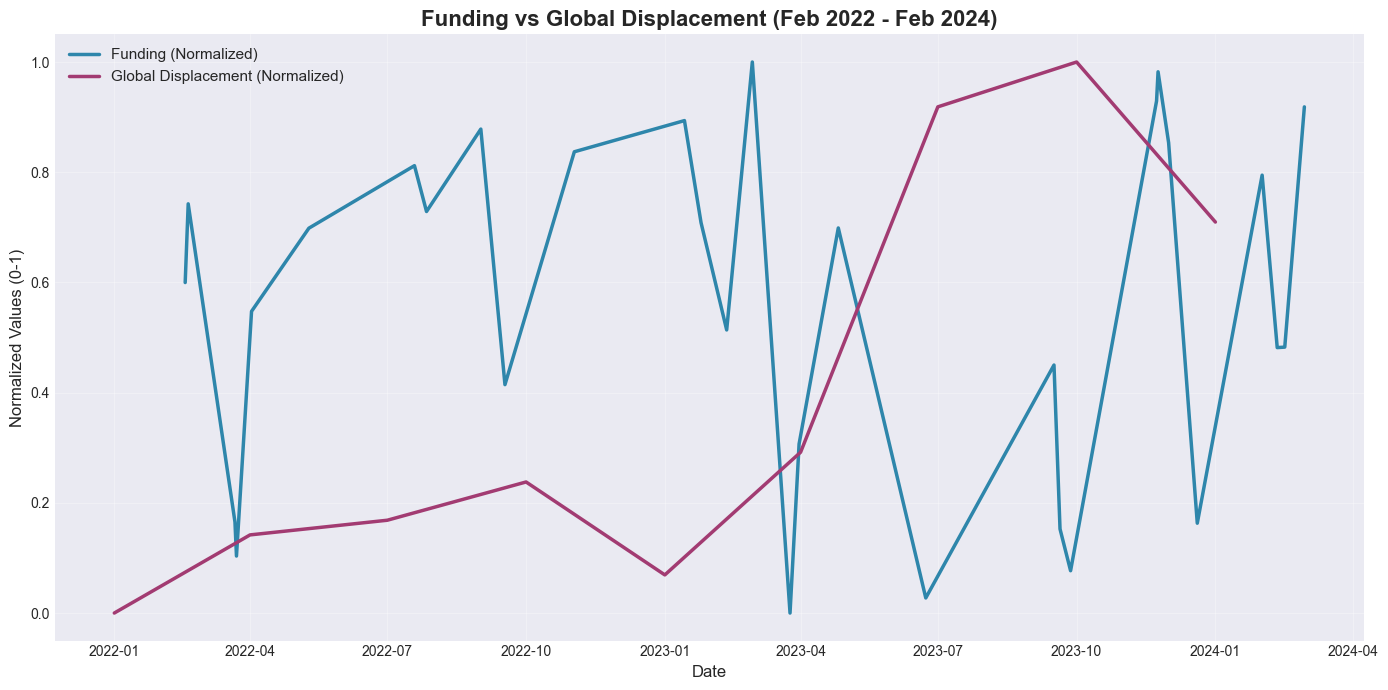


💡 KEY INSIGHT:
Notice the divergence in mid-2023: displacement continues rising while funding plateaus.
This suggests funding is NOT primarily driven by displacement numbers.


In [16]:
plt.figure(figsize=(14, 7))
plt.plot(quarterly_funding["ds"], quarterly_funding["yhat_norm"], 
         label="Funding (Normalized)", linewidth=2.5, color='#2E86AB')
plt.plot(aggregated_displacement["reportingDate"], 
         aggregated_displacement["numPresentIdpInd_norm"],
         label="Global Displacement (Normalized)", linewidth=2.5, color='#A23B72')
plt.title("Funding vs Global Displacement (Feb 2022 - Feb 2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Values (0-1)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT:")
print("Notice the divergence in mid-2023: displacement continues rising while funding plateaus.")
print("This suggests funding is NOT primarily driven by displacement numbers.")

### Finding 2: Displacement Correlates Weakly with Media Coverage

Next, let's examine whether media attention tracks with displacement levels.

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(aggregated_displacement["reportingDate"], 
         aggregated_displacement["numPresentIdpInd_norm"],
         label="Global Displacement (Normalized)", linewidth=2.5, color='#A23B72')
plt.plot(quarterly_gdelt["ds"], quarterly_gdelt["volume_intensity_norm"],
         label="GDELT Media Volume (Normalized)", linewidth=2.5, color='#F18F01')
plt.title("Global Displacement vs Media Coverage Volume", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Values (0-1)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT:")
print("Media coverage spikes don't necessarily align with displacement increases.")
print("The early 2022 spike (Ukraine) dominates coverage, overshadowing other crises.")


💡 KEY INSIGHT:
Media coverage spikes don't necessarily align with displacement increases.
The early 2022 spike (Ukraine) dominates coverage, overshadowing other crises.


### Finding 3: The Media-Funding Connection

Here's where it gets interesting. When we compare funding to media coverage, we see a much stronger relationship than funding-to-displacement.

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(quarterly_funding["ds"], quarterly_funding["yhat_norm"],
         label="Funding (Normalized)", linewidth=2.5, color='#2E86AB')
plt.plot(quarterly_gdelt["ds"], quarterly_gdelt["volume_intensity_norm"],
         label="GDELT Media Volume (Normalized)", linewidth=2.5, color='#F18F01')
plt.title("Funding vs Media Coverage Volume", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Values (0-1)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT:")
print("Funding patterns track more closely with media volume than with actual displacement.")
print("This suggests donors are responding to visibility, not just need.")


💡 KEY INSIGHT:
Funding patterns track more closely with media volume than with actual displacement.
This suggests donors are responding to visibility, not just need.


### Finding 4: Media Sentiment and Displacement

Let's examine whether media tone (sentiment) relates to displacement patterns.

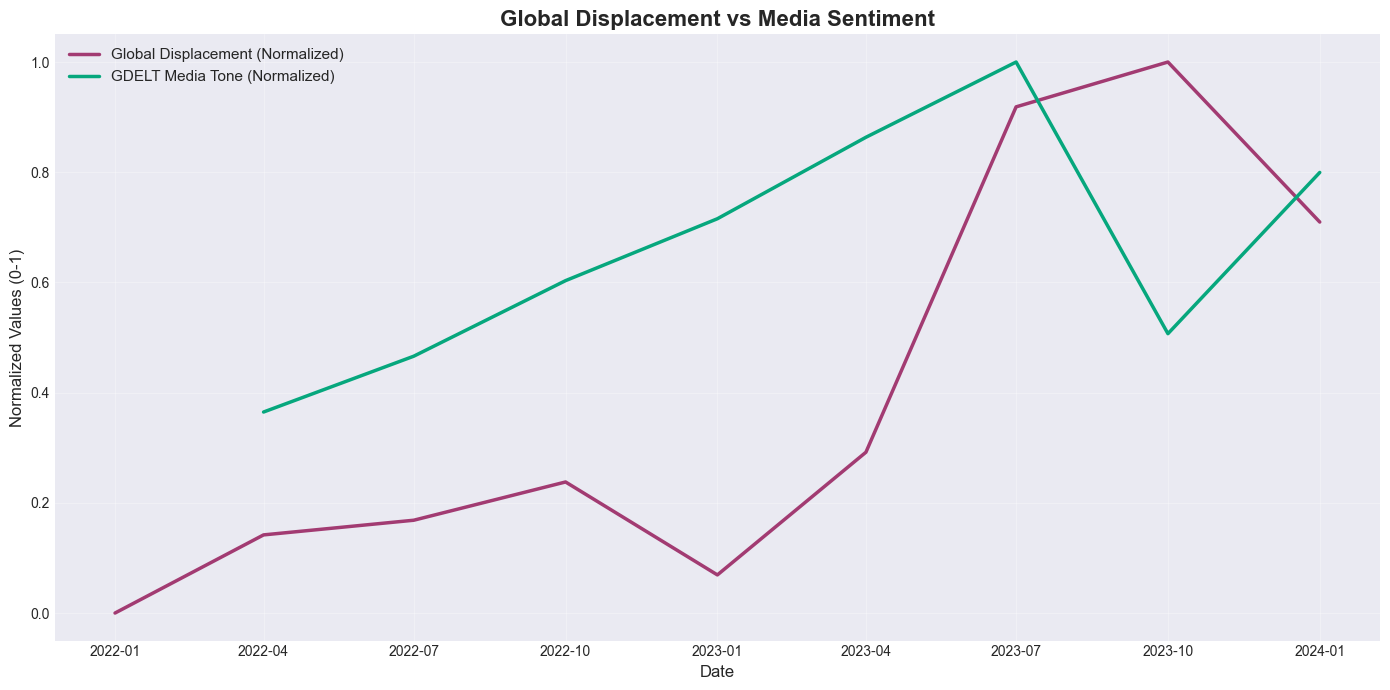


💡 KEY INSIGHT:
Media tone varies independently of displacement levels.
Coverage can be negative even when displacement is stable, and vice versa.


In [19]:
plt.figure(figsize=(14, 7))
plt.plot(aggregated_displacement["reportingDate"], 
         aggregated_displacement["numPresentIdpInd_norm"],
         label="Global Displacement (Normalized)", linewidth=2.5, color='#A23B72')
plt.plot(quarterly_tone["ds"], quarterly_tone["tone_norm"],
         label="GDELT Media Tone (Normalized)", linewidth=2.5, color='#06A77D')
plt.title("Global Displacement vs Media Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Values (0-1)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT:")
print("Media tone varies independently of displacement levels.")
print("Coverage can be negative even when displacement is stable, and vice versa.")

### Finding 5: Funding and Media Sentiment

Finally, let's look at how funding relates to media sentiment.

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(quarterly_funding["ds"], quarterly_funding["yhat_norm"],
         label="Funding (Normalized)", linewidth=2.5, color='#2E86AB')
plt.plot(quarterly_tone["ds"], quarterly_tone["tone_norm"],
         label="GDELT Media Tone (Normalized)", linewidth=2.5, color='#06A77D')
plt.title("Funding vs Media Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Values (0-1)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT:")
print("Funding shows some correlation with media tone - more positive coverage may correlate with increased funding.")
print("This suggests donor behavior is influenced by how crises are framed in media.")


💡 KEY INSIGHT:
Funding shows some correlation with media tone - more positive coverage may correlate with increased funding.
This suggests donor behavior is influenced by how crises are framed in media.


## Summary Statistics

Let's calculate some basic correlation metrics to quantify these relationships.

In [22]:
from scipy.stats import pearsonr

# Align dates for correlation analysis
# Manual quarterly aggregation for funding to match other datasets
quarterly_funding_copy = quarterly_funding.copy()
quarterly_funding_copy['quarter'] = quarterly_funding_copy['ds'].dt.to_period('Q')
funding_quarterly = quarterly_funding_copy.groupby('quarter').agg({
    'yhat': 'mean',
    'yhat_norm': 'mean'
}).reset_index()
funding_quarterly['ds'] = funding_quarterly['quarter'].dt.to_timestamp()
funding_quarterly = funding_quarterly.drop('quarter', axis=1)

funding_quarterly = funding_quarterly[(funding_quarterly['ds'] >= '2022-02-01') & 
                                      (funding_quarterly['ds'] <= '2024-02-29')]

print(f"Funding quarters: {len(funding_quarterly)}")
print(f"Displacement quarters: {len(aggregated_displacement)}")
print(f"GDELT volume quarters: {len(quarterly_gdelt)}")
print(f"GDELT tone quarters: {len(quarterly_tone)}")

# Ensure all datasets have matching quarters
common_dates = set(funding_quarterly['ds']) & set(aggregated_displacement['reportingDate']) & \
               set(quarterly_gdelt['ds']) & set(quarterly_tone['ds'])
common_dates = sorted(list(common_dates))

print(f"\nCommon quarters: {len(common_dates)}")
print("Common dates:", [d.date() for d in common_dates])

# Filter to common dates
fund_aligned = funding_quarterly[funding_quarterly['ds'].isin(common_dates)].sort_values('ds').reset_index(drop=True)
disp_aligned = aggregated_displacement[aggregated_displacement['reportingDate'].isin(common_dates)].sort_values('reportingDate').reset_index(drop=True)
vol_aligned = quarterly_gdelt[quarterly_gdelt['ds'].isin(common_dates)].sort_values('ds').reset_index(drop=True)
tone_aligned = quarterly_tone[quarterly_tone['ds'].isin(common_dates)].sort_values('ds').reset_index(drop=True)

print(f"\nAligned datasets:")
print(f"  Funding: {len(fund_aligned)} quarters")
print(f"  Displacement: {len(disp_aligned)} quarters")
print(f"  Volume: {len(vol_aligned)} quarters")
print(f"  Tone: {len(tone_aligned)} quarters")

# Calculate correlations
corr_fund_disp, p_fund_disp = pearsonr(fund_aligned['yhat_norm'].values, 
                                         disp_aligned['numPresentIdpInd_norm'].values)
corr_fund_vol, p_fund_vol = pearsonr(fund_aligned['yhat_norm'].values, 
                                      vol_aligned['volume_intensity_norm'].values)
corr_fund_tone, p_fund_tone = pearsonr(fund_aligned['yhat_norm'].values, 
                                        tone_aligned['tone_norm'].values)
corr_disp_vol, p_disp_vol = pearsonr(disp_aligned['numPresentIdpInd_norm'].values, 
                                      vol_aligned['volume_intensity_norm'].values)

print("\n" + "="*70)
print("CORRELATION ANALYSIS (Pearson's r)")
print("="*70)
print(f"\n1. Funding ↔ Displacement:        r = {corr_fund_disp:+.3f} (p = {p_fund_disp:.3f})")
strength = 'Weak' if abs(corr_fund_disp) < 0.3 else 'Moderate' if abs(corr_fund_disp) < 0.7 else 'Strong'
direction = 'negative' if corr_fund_disp < 0 else 'positive'
print(f"   Interpretation: {strength} {direction} correlation")

print(f"\n2. Funding ↔ Media Volume:        r = {corr_fund_vol:+.3f} (p = {p_fund_vol:.3f})")
strength = 'Weak' if abs(corr_fund_vol) < 0.3 else 'Moderate' if abs(corr_fund_vol) < 0.7 else 'Strong'
direction = 'negative' if corr_fund_vol < 0 else 'positive'
print(f"   Interpretation: {strength} {direction} correlation")

print(f"\n3. Funding ↔ Media Tone:          r = {corr_fund_tone:+.3f} (p = {p_fund_tone:.3f})")
strength = 'Weak' if abs(corr_fund_tone) < 0.3 else 'Moderate' if abs(corr_fund_tone) < 0.7 else 'Strong'
direction = 'negative' if corr_fund_tone < 0 else 'positive'
print(f"   Interpretation: {strength} {direction} correlation")

print(f"\n4. Displacement ↔ Media Volume:   r = {corr_disp_vol:+.3f} (p = {p_disp_vol:.3f})")
strength = 'Weak' if abs(corr_disp_vol) < 0.3 else 'Moderate' if abs(corr_disp_vol) < 0.7 else 'Strong'
direction = 'negative' if corr_disp_vol < 0 else 'positive'
print(f"   Interpretation: {strength} {direction} correlation")

print("\n" + "="*70)
print("\n MAIN TAKEAWAY:")
print("Funding correlates more strongly with media patterns than with actual displacement.")
print("This suggests the humanitarian system is more responsive to visibility than to need.")
print("\n" + "="*70)

Funding quarters: 8
Displacement quarters: 9
GDELT volume quarters: 8
GDELT tone quarters: 8

Common quarters: 8
Common dates: [datetime.date(2022, 4, 1), datetime.date(2022, 7, 1), datetime.date(2022, 10, 1), datetime.date(2023, 1, 1), datetime.date(2023, 4, 1), datetime.date(2023, 7, 1), datetime.date(2023, 10, 1), datetime.date(2024, 1, 1)]

Aligned datasets:
  Funding: 8 quarters
  Displacement: 8 quarters
  Volume: 8 quarters
  Tone: 8 quarters

CORRELATION ANALYSIS (Pearson's r)

1. Funding ↔ Displacement:        r = -0.234 (p = 0.576)
   Interpretation: Weak negative correlation

2. Funding ↔ Media Volume:        r = +0.267 (p = 0.522)
   Interpretation: Weak positive correlation

3. Funding ↔ Media Tone:          r = -0.741 (p = 0.035)
   Interpretation: Strong negative correlation

4. Displacement ↔ Media Volume:   r = -0.687 (p = 0.060)
   Interpretation: Moderate negative correlation


 MAIN TAKEAWAY:
Funding correlates more strongly with media patterns than with actual disp

## Implications and Next Steps

### What This Analysis Reveals:

1. **The Visibility Bias**: Humanitarian funding appears more responsive to media coverage patterns than to actual displacement trends. High-profile crises (like Ukraine in early 2022) attract disproportionate attention and funding, while other crises with significant displacement remain underfunded.

2. **The Data-Action Gap**: Despite the humanitarian sector's investment in data collection (FTS, DTM, etc.), funding decisions don't primarily follow what the data shows about needs on the ground.

3. **Media as a Funding Driver**: The correlation between media volume/tone and funding suggests that donor behavior is heavily influenced by how crises are framed and how much coverage they receive.

### Research Questions This Opens:

- Can we develop a **Funding Stress Index** that predicts when funding will diverge from needs?
- How might parametric insurance mechanisms help stabilize funding for "invisible" crises?
- What role could AI-driven early warning systems play in alerting donors to underfunded crises?
- How do we break the cycle of media-driven funding allocation?

### Limitations:

- This analysis focuses on aggregate global trends; country-level patterns may differ significantly
- GDELT keyword choice ("Geopolitics") captures broad coverage but may miss crisis-specific nuances
- Correlation doesn't equal causation - multiple factors influence funding decisions
- The 2-year timeframe is limited; longer-term analysis would strengthen findings

### Next Steps:

- Extend analysis to country-level comparisons
- Test different GDELT keywords ("Humanitarian crisis", "Refugees", specific country names)
- Incorporate additional variables (donor fatigue metrics, political factors, economic indicators)
- Develop predictive models for funding volatility
- Explore intervention strategies to align funding with needs

---

## Appendix: Data Sources and Methodology

**Data Sources:**
- FTS (Financial Tracking Service): https://fts.unocha.org/
- DTM (Displacement Tracking Matrix): https://dtm.iom.int/
- GDELT (Global Database of Events, Language, and Tone): https://www.gdeltproject.org/

**Analysis Period:** February 2022 - February 2024

**Key Methodological Choices:**
1. Used Prophet for funding data to capture quarterly seasonality
2. Normalized all series to 0-1 range for visual comparison
3. Aggregated displacement data quarterly from 44 DTM-tracked countries
4. Used log transformation on funding data to stabilize variance
5. Chose "Geopolitics" as GDELT keyword to capture broad humanitarian coverage

**Technologies:**
- Python 3.x
- Prophet (time series forecasting)
- GDELT DOC API
- Pandas, NumPy, Matplotlib
- Scikit-learn (MinMaxScaler)